In [2]:
import hydroeval as he
import time
import glob
import xarray as xr
import numpy as np
from PIL import Image
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
# from torchvision import transforms, models
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import warnings
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 12
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"

from datetime import datetime
from pytz import timezone

# import scipy.ndimage
east = timezone('US/Eastern')


warnings.filterwarnings("ignore")




Basin Selected: Bear River
NVIDIA GeForce RTX 2080 Ti
Training started at 2022-06-25 13:53:14
Epoch 0 train:	 [0.51]
Epoch 1 train:	 [0.88]
Epoch 2 train:	 [0.94]
Training time 0.17870 (minutes)

KGE	[0.94817385] 
r	 [0.98375308] 
α	 [0.97516543] 
β	 [0.95751199]
NSE [0.9666669]


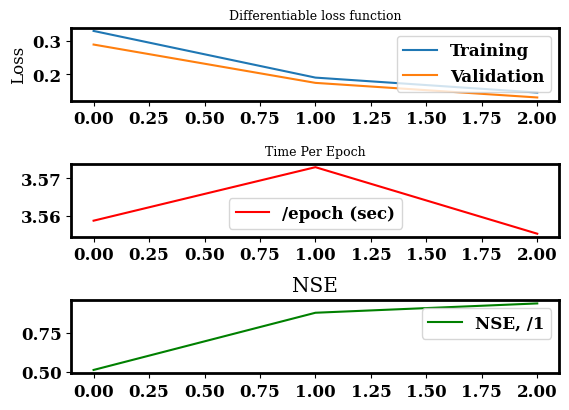

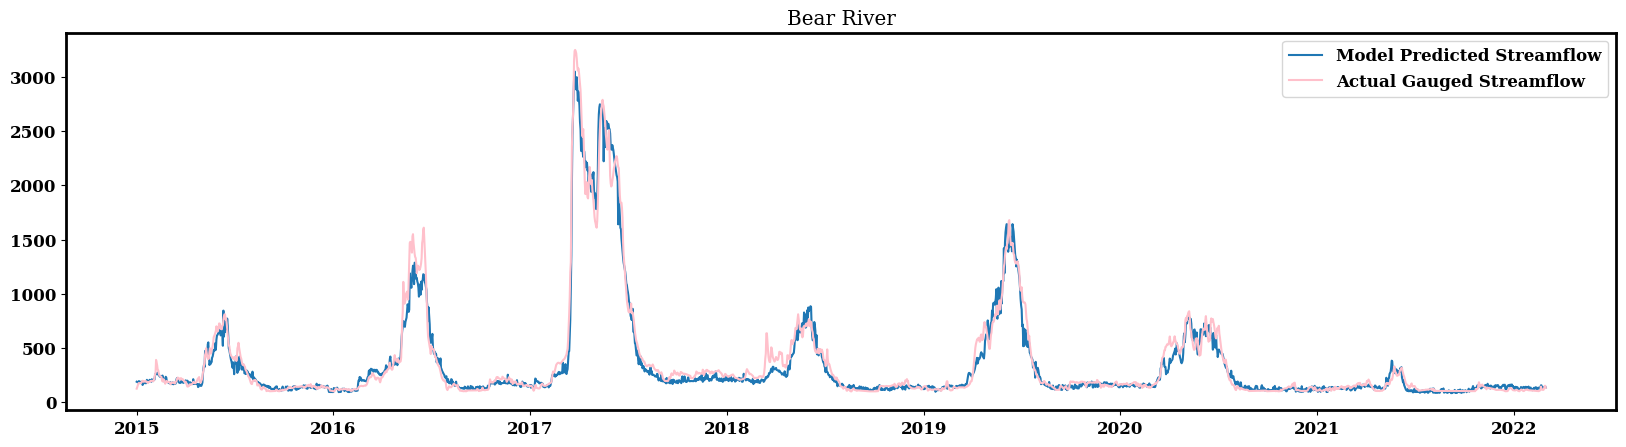

In [4]:
basin_idx = 0 ##br = 0, co = 1, ct = 2, ms = 3
lag = 0
epochs = 500
stop = .90 #stop at this training nse
tt_split = 0.95
stripchart = (15,5)
image = (10,10)

if basin_idx == 3:
    batch_size=1
else:
    batch_size=2

def nc2torch(i):
    return torch.from_numpy(np.asarray(i)).unsqueeze(0)

#gauged flow final handling
def interp__and__totensor(x):
    x = pd.Series(x).interpolate().tolist()
    return torch.from_numpy(np.asarray(x)).unsqueeze(1).unsqueeze(1).unsqueeze(1)

if lag == 0:
    times = np.arange(np.datetime64('2015-01-01'),
                      np.datetime64('2022-03-02'), np.timedelta64(1, 'D'))
    
##x-axis becomes time of prediction, with the actual prediction and modeled prediction displayed on the plot.
else:
    times = np.arange(np.datetime64('2015-01-01'),
                      np.datetime64('2022-03-02') - np.timedelta64(lag, 'D'), np.timedelta64(1, 'D'))

basin = ['Bear River','Colorado','Connecticut','Mississippi']
basincode = ['br','co','ct','ms']
basinvectorsize = [14*13,98*89,30*14,165*286]
br_co_ct_ms = np.load('br_co_ct_ms.npy')
br_co_ct_ms_times = np.load('br_co_ct_ms_times.npy')
br_co_ct_ms = np.where(br_co_ct_ms < -100000,np.nan,br_co_ct_ms)

for xdx,x in enumerate(br_co_ct_ms):
    if xdx == 0:
        y = interp__and__totensor(x)
    else:
        y = torch.cat((y,interp__and__totensor(x)),axis=1)
sf = torch.permute(y,[1,0,2,3])

#plot flows, not necessary but can look @ interpolated and non interpolated.
# plt.figure(figsize=(stripchart))
# plt.title('Gauged streamflow')
# plt.plot(times,br_co_ct_ms[basin_idx])
# plt.plot(times,sf[basin_idx,:,0,0])
# plt.legend(['No Interp','Interp'],loc='best')

#final NLDAS Qs & Qsb handling handling
imz = torch.load(f'nldas_{basincode[basin_idx]}.pt')
imz = torch.flip(imz,[2])
Qs = imz[:,0]
Qsb = imz[:,1]
Qz = [Qs, Qsb]

#plots sample image
# plt.figure(figsize=(image))
# plt.title('Sample of Qs basin')
# plt.imshow(Qs[1000],cmap='cividis')
# plt.colorbar()
# plt.gca().set_aspect('equal')

#zscores Qs

def zscore(x):
    x = x.numpy()
    x = np.where((x>0) & (x<1000) == True,x,0)
    np_nanmean = np.nanmean(x)
    np_nanstd = np.nanstd(x)
    zscored = (x-np_nanmean)/np_nanstd
    zscored = np.where(np.isfinite(zscored) == False,0,zscored)
    return zscored

zscoredQs = []
for y in Qs:
    z = zscore(y)
    zscoredQs.append(z)
zscoredQs = torch.from_numpy(np.asarray(zscoredQs)).unsqueeze(1)

#zscores Qsb
zscoredQsb = []
for y in Qsb:
    z = zscore(y)
    zscoredQsb.append(z)
zscoredQsb = torch.from_numpy(np.asarray(zscoredQsb)).unsqueeze(1)
zscoredQz = torch.cat((zscoredQs,zscoredQsb),axis=1)

# plt.figure(figsize=image)
# plt.title('Sample zscored Qs')
# plt.imshow(zscoredQz[1000,0],cmap='cividis')
# plt.colorbar(fraction=.025)

if lag == 0:
    imz__lag = zscoredQz
else:
    imz__lag = zscoredQz[:-lag]
streamz__lag = sf[basin_idx,:,0,0][lag:].unsqueeze(1).unsqueeze(1).unsqueeze(1).to(torch.float32)

print(f"\n\n\nBasin Selected: {basin[basin_idx]}")

torch.cuda.empty_cache()
torch.cuda.current_device()
# print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0)    

class setter2(Dataset):
    def __init__(self,x,y,z):
        self.x = x[:z]
        self.y = y[:z]
        # self.x = torch.load(x)[:z]
        # self.y = torch.load(y)[:z]
        self.std,self.mean = torch.std_mean(self.y)
        self.y = (self.y - self.mean)/self.std
        self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        y = self.y[idx].to('cuda')
        return x, y
    def __len__(self):
        return self.x.shape[0]

class LARSONet(torch.nn.Module):
    def __init__(self):
        super(LARSONet,self).__init__()
#         # in layer
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(2):
            hidden_layers.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(64))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
        self.linear1 = torch.nn.Linear(basinvectorsize[basin_idx],100) ### this is what gets changed based on important switch
        self.linear2 = torch.nn.Linear(100,50)
        self.linear3 = torch.nn.Linear(50,20)
        self.linear4 = torch.nn.Linear(20,10)
        self.linear5 = torch.nn.Linear(10,1)
    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.mid_layer(out1)
        o = self.conv3(out+out1)
        o = self.linear1(o.view(o.size(0),-1))
        o = self.relu(self.linear2(o))
        o = self.relu(self.linear3(o))
        o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o

streamz = streamz__lag
imz = imz__lag



dset = setter2(imz,streamz,streamz__lag.shape[0]) #imz, streamz, shape (could be either streamz__lag or imz__lag shape [0]
cube_height = dset.x.shape[2]
cube_width = dset.x.shape[3]

train_dset_size = int(tt_split*len(dset))
valid_dset_size = int(len(dset) - train_dset_size)
train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])

# train = Subset(dset,range(0,train_dset_size))
# valid = Subset(dset,range(train_dset_size,train_dset_size+valid_dset_size))

train_dataloader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=True)

model = LARSONet()
model.apply(weights_init)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = torch.nn.L1Loss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)

print('Training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
nse_during = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    train_pred = torch.empty((0,1)).to('cuda')
    train_y = torch.empty((0,1)).to('cuda')
    # val_pred = torch.empty((0,1)).to('cuda')
    # val_y = torch.empty((0,1)).to('cuda')
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
        train_pred = torch.cat((train_pred,predicted.reshape(-1,1)))
        train_y = torch.cat((train_y,y.reshape(-1,1)))
        loss = criterion(predicted.reshape(-1),y.reshape(-1))
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred.reshape(-1),yy.reshape(-1))
        v_e_loss += loss2.item()
        # val_pred = torch.cat((val_pred,v_pred.reshape(-1,1)))
        # val_y = torch.cat((val_y,yy.reshape(-1,1)))
    nse_epoch_train = he.evaluator(he.nse,train_pred.cpu().detach().numpy(),train_y.cpu().detach().numpy())
    # nse_epoch_valid = he.evaluator(he.nse,val_pred.cpu().detach().numpy(),val_y.cpu().detach().numpy())
    print(f"Epoch {i} train:\t {np.around(nse_epoch_train,2)}")
    nse_during.append(nse_epoch_train)
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
    if nse_epoch_train > stop:
        break
t1 = time.time()
print('Training time {} (minutes)'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(311)
plt.title('Differentiable loss function',fontsize=9)
plt.plot(t_loss)
plt.plot(v_loss)
plt.legend(['Training','Validation'])
plt.ylabel('Loss')
fig.add_subplot(312)
plt.title('Time Per Epoch',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)'])
fig.add_subplot(313)
plt.title('NSE')
plt.plot(nse_during,color='green')
plt.legend(['NSE, /1'])






#inference

torch.cuda.empty_cache()
torch.cuda.current_device()
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

imageTensor = imz
streamTensor = streamz

class setter2infer(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
        self.std,self.mean = torch.std_mean(self.y)
        self.y = (self.y - self.mean)/self.std

        # print('shape of x',self.x.shape)
        # print('shape of y',self.y.shape)
        
        # self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]


test_dset = setter2infer(imageTensor,streamTensor)
# test = Subset(test_dset,range(673,841))
train_dataloader = DataLoader(dataset=test_dset, batch_size=1, shuffle=False)


test_predictions = []
with torch.no_grad():
    for xx,yy in train_dataloader:
        test_pred = model(xx)
        # print(test_pred.shape)
        test_predictions.append(test_pred)

test_streamflows = [(x*dset.std)+dset.mean for x in test_predictions]
test_streamflows = torch.Tensor(test_streamflows)
test_streamflows = test_streamflows.numpy()
# print(test_streamflows.shape)
# test_streamflows = np.where(test_streamflows>200000,test_streamflows,200000)
streamz_actual = sf[basin_idx,:,0,0].numpy()

plt.figure(figsize=(20,5))
plt.plot(times,test_streamflows,linewidth=1.5)
plt.plot(times,streamz_actual[lag:],color='pink',linewidth=1.5)
plt.legend(['Model Predicted Streamflow','Actual Gauged Streamflow'])
plt.title(f'{basin[basin_idx]}')

# print(test_streamflows.shape)
# print(streamz_actual.shape)

kge, r, alpha, beta = he.evaluator(he.kge,test_streamflows,streamz_actual[lag:])
print(f'\nKGE\t{kge} \nr\t {r} \nα\t {alpha} \nβ\t {beta}')

nse = he.evaluator(he.nse,test_streamflows,streamz_actual[lag:])
print(f'NSE {nse}')

In [5]:
torch.save(model,'br_nse96.pt')
# saving good run of bear river.